In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

> PS : Still new in NLP so I really appreciate any advice regarding the structure of the notebook.

<div style="color:white;display:fill;
            background-color:#00bbe0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>Table of Contents</b></p>
</div>

<a id="toc"></a>

- [1.1 Importing Libraries and Data](#1)

        
- [2.1 EDA](#2)


- [3.1 Text Preprocessing](#3)


- [4.1 Model Creatiion and Training](#4)
    - 4.2 Splitting Train and Test datasets
    - 4.3 Importing transformers
    - 4.4 Bert Tokenizer creation
    - 4.5 Datasets creation for train and test using tensorflow and tokenizer
    - 4.6 Bert Model Creation
    - 4.7 Training


- [5.1 Prediction and Submission](#5)



<a id="1"></a>

<div style="color:white;display:fill;
            background-color:#00bbe0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.1 Importing Libraries and Data</b></p>
</div>

* importing bert offline model from huggingface-bert-variants kaggle dataset

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', font_scale=1)

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_df = pd.read_csv('sample_submission.csv')

# Checking for null values
train_df.isnull().sum() ,train_df.shape

(text_id        0
 full_text      0
 cohesion       0
 syntax         0
 vocabulary     0
 phraseology    0
 grammar        0
 conventions    0
 dtype: int64, (3911, 8))

<a id="2"></a>

<div style="color:white;display:fill;
            background-color:#00bbe0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.1 EDA</b></p>
</div>



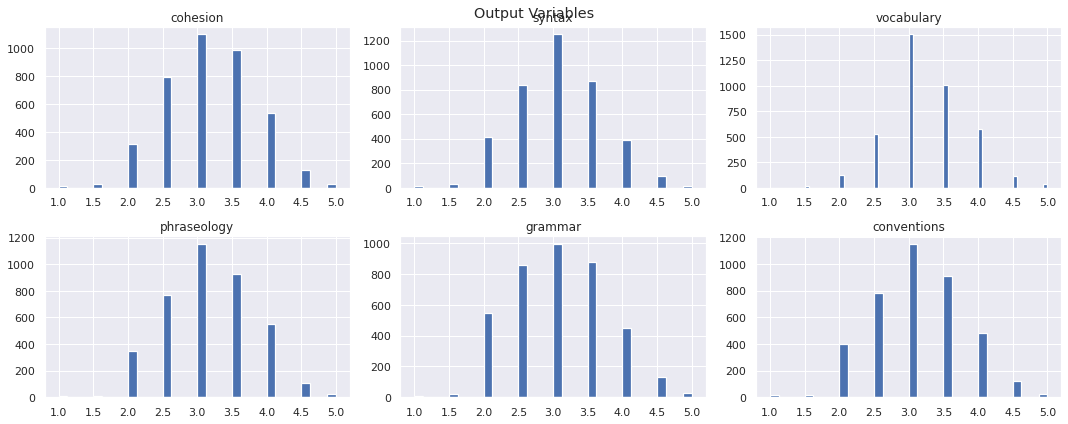

In [80]:
targets = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

fig, axes = plt.subplots(2, len(targets)//2, figsize=(15,6))

for i, target in enumerate(targets):
    ax = axes.flat[i]
    sns.histplot(x=target, data=train_df, linewidth=1.25, alpha=1, ax=ax, zorder=2)
    ax.set_title(target)
    ax.set(xlabel=None, ylabel=None)
    
fig.suptitle('Output Variables')
plt.tight_layout()
plt.show()


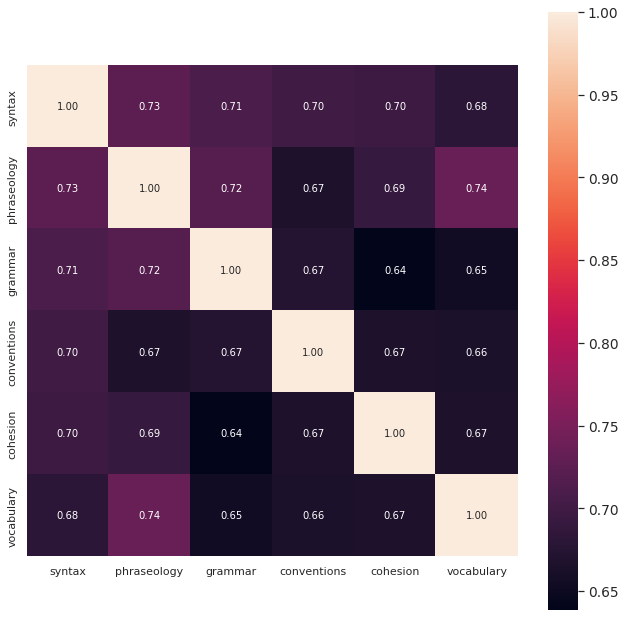

Index(['syntax', 'phraseology', 'grammar', 'conventions', 'vocabulary'], dtype='object')

In [81]:
k = len(train_df.columns) #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = train_df.corr().abs().nlargest(k, 'syntax')['syntax'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
cols = cols.drop('cohesion')
cols

<a id="3"></a>

<div style="color:white;display:fill;
            background-color:#00bbe0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.1 Text Preprocessing</b></p>
</div>

In [82]:
# Merging Train and Test Data
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['text_id'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (3914, 7)


In [83]:
import string
import nltk
from nltk.corpus import stopwords
nltk.download('popular')
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

# Create an instance of a PorterStemmer object
lemmatizer = WordNetLemmatizer()

def preprocess(phrase):

  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can't", "can not", phrase)
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  phrase = phrase.replace('\\r', ' ')
  phrase = phrase.replace('\\n', ' ')
  phrase = phrase.replace('\\"', ' ')
  phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
  

  return phrase


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [84]:
test = 'Our \'fffff\'Deeds are the . Reason of @insta this #earthquake M'
print(preprocess(test))

Our fffff Deeds are the Reason of insta this earthquake M


In [85]:
all_data['full_text'] = all_data['full_text'].apply(lambda text : preprocess(text))

<a id="4"></a>

<div style="color:white;display:fill;
            background-color:#00bbe0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.1 Model Creation and Training</b></p>
</div>

#### 4.2 Splitting Train and Test datasets

In [86]:
train_data = all_data[:ntrain].copy()
test_data = all_data[ntrain:]

train_data.shape , test_data.shape

((3911, 7), (3, 7))

In [110]:
BATCH_SIZE = 6

MAX_LEN = 512

#### 4.3 Importing transformers

In [111]:
import tensorflow as tf
! pip install transformers
from transformers import BertTokenizer , TFBertModel 

AUTO = tf.data.experimental.AUTOTUNE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### 4.3 Bert Tokenizer creation

#### 4.4 Datasets creation for train and test using tensorflow and tokenizer

In [112]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [113]:
def encode(input_text):
    inputs = tokenizer.batch_encode_plus(input_text,padding='max_length',max_length=MAX_LEN, truncation=True)
    return inputs

In [114]:
train_input = encode(train_data['full_text'].values.tolist())['input_ids']

train_data_ds = (
    tf.data.Dataset
    .from_tensor_slices((train_input,train_data.drop('full_text', axis = 1)))
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [115]:
testing_input = encode(test_data.full_text.values.tolist())['input_ids']

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(testing_input)
    .batch(BATCH_SIZE)
)

#### Helper functions

In [116]:
# Custom error function MCRMSE : column wise root mean squared eoor
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)

In [117]:
from transformers import DistilBertConfig
def create_model():
    
    bert_encoder = TFBertModel.from_pretrained('bert-base-cased')
    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")

    embedding = bert_encoder(input_word_ids)[0]
    x = tf.keras.layers.GlobalAveragePooling1D()(embedding)
    x = tf.keras.layers.LayerNormalization()(x)
    #Output layer without activation function because regression task
    output = tf.keras.layers.Dense(6,)(x)

    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=MCRMSE
                  , metrics=MCRMSE)

    return model

#### 4.5 Bert Model creation

In [118]:
model= create_model()
model.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 512)]            0         
                                                                 
 tf_bert_model_4 (TFBertMode  TFBaseModelOutputWithPoo  108310272
 l)                          lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             512, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

In [119]:
import  gc
gc.collect()

42805

In [120]:
BATCH_SIZE

6

#### 4.6 Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback = tf.keras.callbacks.EarlyStopping(monitor='MCRMSE', patience = 2 ,restore_best_weights=True)

history = model.fit(
                    train_data_ds, 
                    steps_per_epoch= train_data.shape[0]//BATCH_SIZE,
                    batch_size = BATCH_SIZE,
                    epochs= 3,
                    verbose = 1,
                    shuffle= True,
                    callbacks=[callback]
                       )

Epoch 1/3


106/651 [===>..........................] - ETA: 5:47:38 - loss: 0.7161 - MCRMSE: 0.7161

<a id="5"></a>

<div style="color:white;display:fill;
            background-color:#00bbe0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>Prediction + Submission</b></p>
</div>

In [ ]:
sub = pd.DataFrame(sample_df)
sub[['cohesion','syntax','vocabulary','phraseology','grammar','conventions']] = model.predict(test_dataset)
sub.to_csv('submission.csv',index=False)
sub

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.140685,2.923225,3.160581,3.042206,2.776313,2.779055
1,000BAD50D026,2.831664,2.536848,2.768464,2.402229,2.251981,2.817396
2,00367BB2546B,3.847869,3.622557,3.685078,3.712913,3.654544,3.789134


# 